In [1]:
import os
import sys
sys.path.extend(["../..", "."])

from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, "..", "..")

from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import allign_metrics, report_alligned_metrics, get_roc, get_preds
from nebula.misc.plots import plot_roc_curve, plot_cv_metrics_dict
from nebula.models.neurlux import NeurLuxModel
from nebula.models.quovadis import QuoVadisModel
from nebula.models import TransformerEncoderChunks
from nebula.constants import SPEAKEASY_LABELMAP
REVERSE_SPEAKEASY_LABELMAP = {v: k for k, v in SPEAKEASY_LABELMAP.items()}
from collections import defaultdict
import numpy as np
import pickle
import json
import torch

RUN_TYPES = ["nebula", "neurlux", "quovadis"]
RUN_NAME = "speakeasy"

INFOLDER = "out_speakeasy_multiclass"

RUN_END_FILTER = "r1763_t5"
run_folders = [x for x in os.listdir(INFOLDER) if x.startswith("cv") and x.endswith(RUN_END_FILTER)]

NEBULA_VOCAB = 50000
NEURLUX_VOCAB = 10000
QUO_VADIS_VOCAB = 600
SEQ_LEN = 512
LIMIT = "full"
# TBD -- see:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [2]:
models = defaultdict(dict)

neurlux_vocab_file = os.path.join(INFOLDER, f"neurlux_{RUN_NAME}_vocab_{NEURLUX_VOCAB}_seqlen_{SEQ_LEN}", f"vocab_{NEURLUX_VOCAB}.json")
quo_vadis_data_folder = os.path.join(INFOLDER, f"quovadis_{RUN_NAME}_vocab_{QUO_VADIS_VOCAB}_seqlen_{SEQ_LEN}")
quo_vadis_vocab_name = [x for x in os.listdir(quo_vadis_data_folder) if x.startswith("vocab")][0]
quovadis_vocab_file = os.path.join(quo_vadis_data_folder, quo_vadis_vocab_name)
nebula_vocab_file = os.path.join(INFOLDER, f"nebula_{RUN_NAME}_vocab_{NEBULA_VOCAB}_seqlen_{SEQ_LEN}", f"tokenizer_{NEBULA_VOCAB}_vocab.json")

with open(neurlux_vocab_file) as f:
    neurlux_vocab = json.load(f)
models['neurlux']['class'] = NeurLuxModel
models['neurlux']['config'] = {
    "embedding_dim": 256,
    "vocab_size": len(neurlux_vocab),
    "seq_len": SEQ_LEN,
    "num_classes": 8
}

models['quovadis']['class'] = QuoVadisModel
models['quovadis']['config'] = {
    "vocab": quovadis_vocab_file,
    "seq_len": SEQ_LEN,
    "num_classes": 8
}

with open(nebula_vocab_file) as f:
    nebula_vocab = json.load(f)
models['nebula']['class'] = TransformerEncoderChunks
models['nebula']['config'] = {
    "vocab_size": len(nebula_vocab),
    "maxlen": SEQ_LEN,
    "chunk_size": 64,
    "dModel": 64,  # embedding & transformer dimension
    "nHeads": 8,  # number of heads in nn.MultiheadAttention
    "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
    "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    "numClasses": 8, # binary classification
    "hiddenNeurons": [64],
    "layerNorm": False,
    "dropout": 0.3,
    "mean_over_sequence": False,
    "norm_first": True
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
metrics_val = defaultdict(list)
model_files = defaultdict(list)
for folder in run_folders:
    key = folder.split("_")[1]
    print(f"[*] In process: {key}")

    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_val_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = defaultdict(list)
        folder = os.path.join(INFOLDER, folder)
        data_splits = read_cv_data_splits(folder)
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]
        
        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                data_splits[i]["X_test"],
                data_splits[i]["y_test"],
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            y_pred = np.argmax(y_pred, axis=1)
            n_unique_classes = len(np.unique(y_true))
            for n in range(n_unique_classes):
                label = REVERSE_SPEAKEASY_LABELMAP[n]
                y_true_n = np.where(y_true == n, 1, 0)
                y_pred_n = np.where(y_pred == n, 1, 0)
                fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true_n, y_pred_n, metrics_full=True)
                #print(f"For class {label} metrics are: fpr: {fpr}, tpr: {tpr}, roc_auc: {roc_auc}, f1: {f1}, recall: {recall}, precision: {precision}, acc: {acc}")
                metrics[label].append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_val[key] = metrics

[*] In process: nebula
[*] Running ROC for split: 0
Evaluating nebula_split_0 | Size: 5397768...


100%|██████████| 265/265 [00:08<00:00, 31.93it/s]


[*] Running ROC for split: 1
Evaluating nebula_split_1 | Size: 5397768...


100%|██████████| 265/265 [00:07<00:00, 34.69it/s]


[*] Running ROC for split: 2
Evaluating nebula_split_2 | Size: 5397768...


100%|██████████| 265/265 [00:07<00:00, 33.67it/s]


[*] In process: neurlux
[*] Running ROC for split: 0
Evaluating neurlux_split_0 | Size: 2794822...


100%|██████████| 265/265 [00:05<00:00, 49.00it/s]


[*] Running ROC for split: 1
Evaluating neurlux_split_1 | Size: 2794822...


100%|██████████| 265/265 [00:03<00:00, 82.66it/s]


[*] Running ROC for split: 2
Evaluating neurlux_split_2 | Size: 2794822...


100%|██████████| 265/265 [00:03<00:00, 80.13it/s]


[*] In process: quovadis
[*] Running ROC for split: 0
Evaluating quovadis_split_0 | Size: 1449352...


100%|██████████| 265/265 [00:03<00:00, 72.38it/s]


[*] Running ROC for split: 1
Evaluating quovadis_split_1 | Size: 1449352...


100%|██████████| 265/265 [00:03<00:00, 72.82it/s]


[*] Running ROC for split: 2
Evaluating quovadis_split_2 | Size: 1449352...


100%|██████████| 265/265 [00:03<00:00, 73.43it/s]


clean
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.004475  0.972893  0.961305  0.967613   0.955102  0.974752
neurlux   0.003486  0.975635  0.960859  0.979979   0.942521  0.974109
quovadis  0.004605  0.958050  0.946272  0.936779   0.956065  0.965531
backdoor
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.015392  0.920938  0.896454  0.849543   0.951042  0.971587
neurlux   0.036178  0.922327  0.892895  0.854517   0.945415  0.970404
quovadis  0.022537  0.892371  0.871144  0.788416   0.973434  0.966122
coinminer
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.016245  0.937070  0.908294  0.879875   0.938765  0.983908
neurlux   0.038378  0.944493  0.922978  0.893131   0.956921  0.986549
quovadis  0.008587  0.928786  0.881135  0.867683   0.895225  0.978825
dropper
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.004148  0.948150  0.874186  0.918500   0.8340

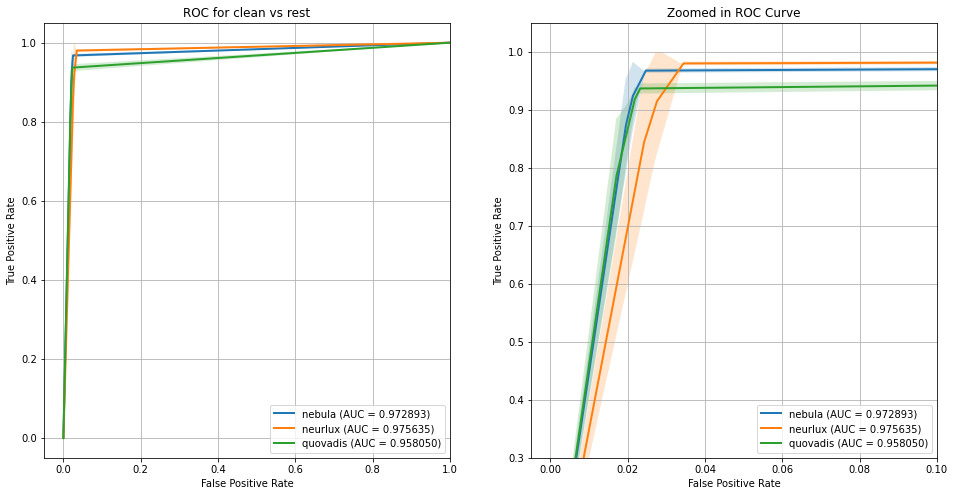

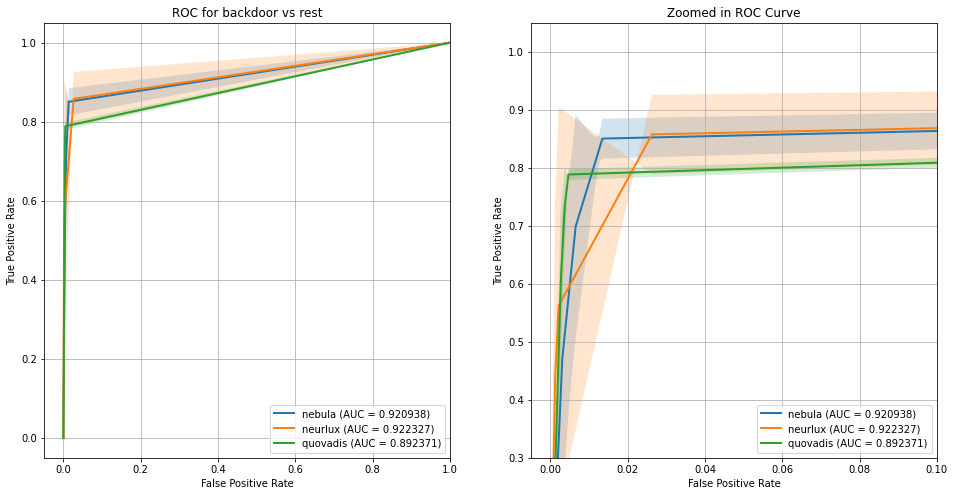

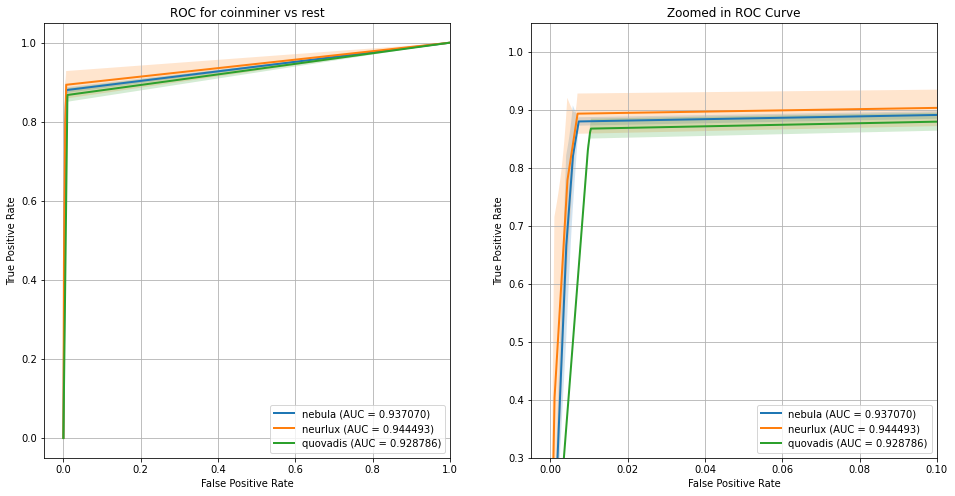

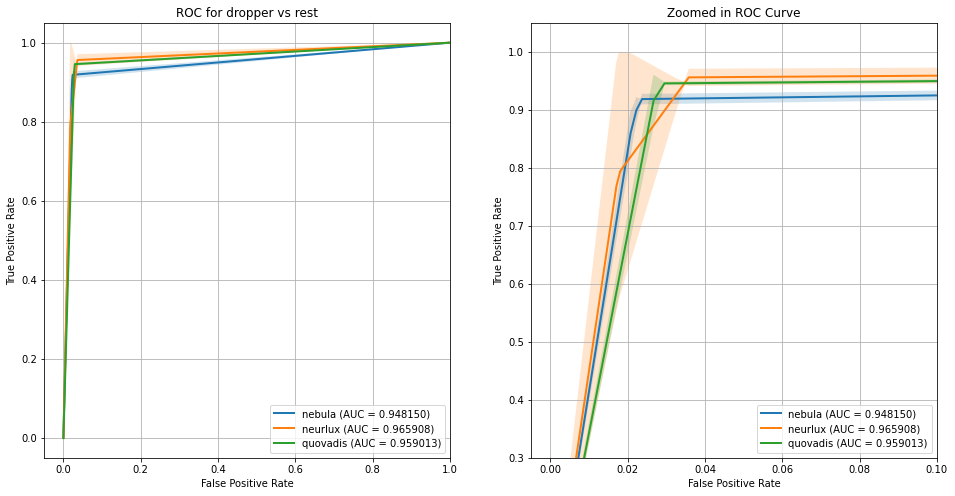

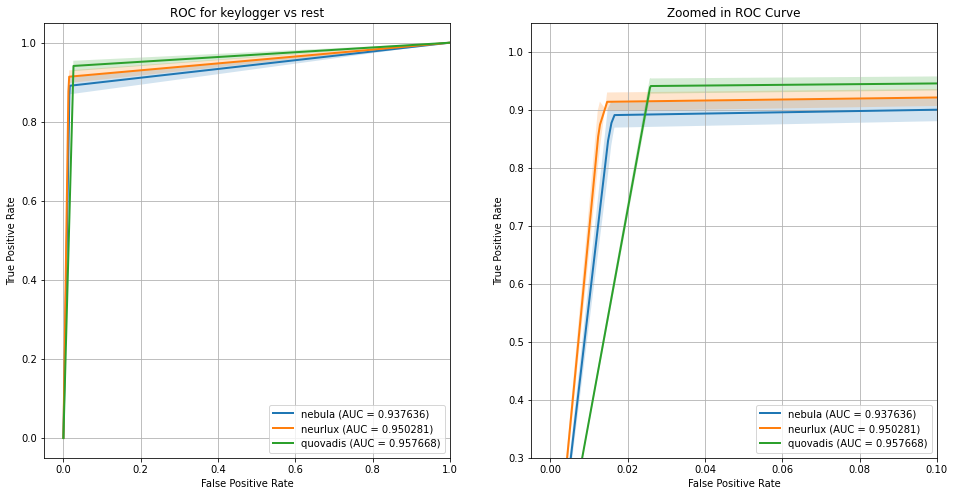

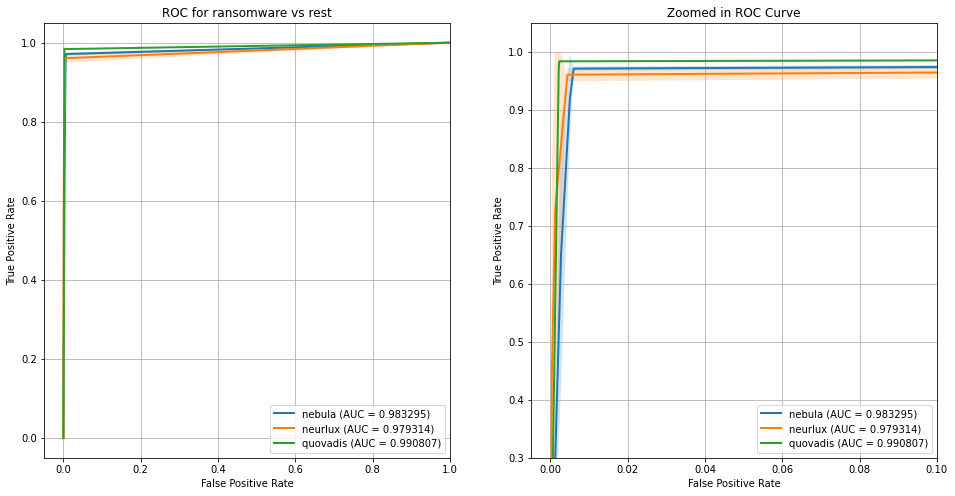

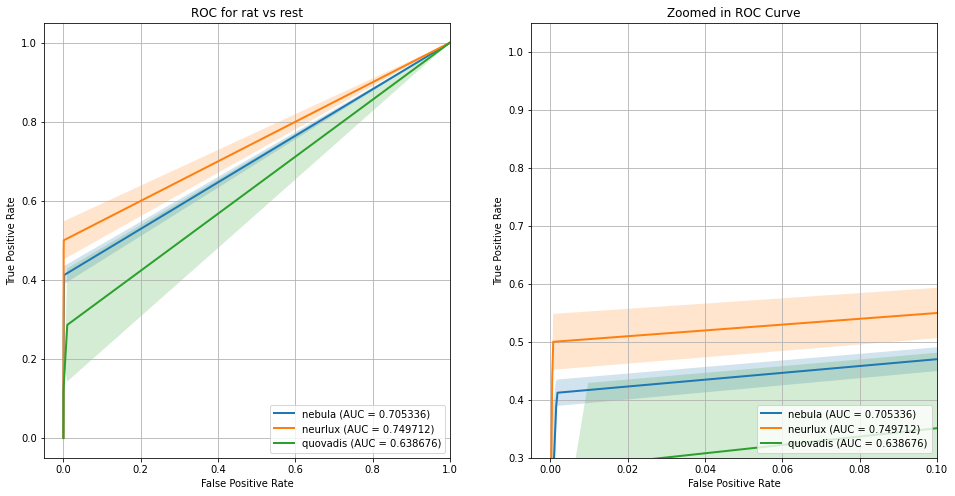

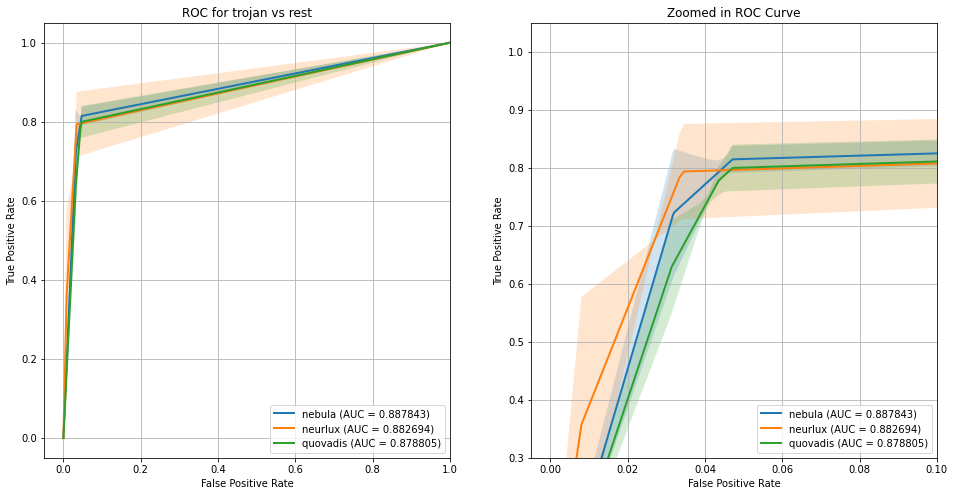

In [4]:
for selected_label in SPEAKEASY_LABELMAP.keys():
    metrics_label = {k: v[selected_label] for k, v in metrics_val.items()}
    base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(metrics_label)

    df, axs_val = report_alligned_metrics(
        base_fpr_val,
        tprs_mean_val,
        tprs_std_val,
        metrics_label,
        xlim=[-0.005, 0.1],
        ylim=[0.3, 1.05],
        metrics_full=True
    )
    # suptitle to refer label
    axs_val[0].set_title(f"ROC for {selected_label} vs rest")
    print(selected_label)
    print(df[df.columns[0:1].tolist() + df.columns[-5:].tolist()])

## Test set ROCs

In [5]:
metrics_test = defaultdict(list)
model_files = defaultdict(list)
for folder in run_folders:
    key = folder.split("_")[1]
    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_test_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = defaultdict(list)
        print(f"[*] In process: {key}")
        folder = os.path.join(INFOLDER, folder)

        data_folder = [x for x in os.listdir(INFOLDER) if x.startswith(key) and "vocab" in x][0]
        X_test = np.load(os.path.join(INFOLDER, data_folder, f"x_test_{LIMIT}.npy"))
        y_test = np.load(os.path.join(INFOLDER, data_folder, f"y_test_{LIMIT}.npy"))

        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]

        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                X_test,
                y_test,
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            y_pred = np.argmax(y_pred, axis=1)
            n_unique_classes = len(np.unique(y_true))
            for n in range(n_unique_classes):
                label = REVERSE_SPEAKEASY_LABELMAP[n]
                y_true_n = np.where(y_true == n, 1, 0)
                y_pred_n = np.where(y_pred == n, 1, 0)
                fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true_n, y_pred_n, metrics_full=True)
                #print(f"For class {label} metrics are: fpr: {fpr}, tpr: {tpr}, roc_auc: {roc_auc}, f1: {f1}, recall: {recall}, precision: {precision}, acc: {acc}")
                metrics[label].append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_test[key] = metrics

[*] In process: nebula
[*] Running ROC for split: 0
Evaluating nebula_split_0 | Size: 5397768...


100%|██████████| 182/182 [00:05<00:00, 32.20it/s]


[*] Running ROC for split: 1
Evaluating nebula_split_1 | Size: 5397768...


100%|██████████| 182/182 [00:05<00:00, 33.15it/s]


[*] Running ROC for split: 2
Evaluating nebula_split_2 | Size: 5397768...


100%|██████████| 182/182 [00:05<00:00, 32.87it/s]


[*] In process: neurlux
[*] Running ROC for split: 0
Evaluating neurlux_split_0 | Size: 2794822...


100%|██████████| 182/182 [00:02<00:00, 78.69it/s]


[*] Running ROC for split: 1
Evaluating neurlux_split_1 | Size: 2794822...


100%|██████████| 182/182 [00:02<00:00, 77.85it/s]


[*] Running ROC for split: 2
Evaluating neurlux_split_2 | Size: 2794822...


100%|██████████| 182/182 [00:02<00:00, 81.34it/s]


[*] In process: quovadis
[*] Running ROC for split: 0
Evaluating quovadis_split_0 | Size: 1449352...


100%|██████████| 182/182 [00:02<00:00, 69.05it/s]


[*] Running ROC for split: 1
Evaluating quovadis_split_1 | Size: 1449352...


100%|██████████| 182/182 [00:02<00:00, 69.45it/s]


[*] Running ROC for split: 2
Evaluating quovadis_split_2 | Size: 1449352...


100%|██████████| 182/182 [00:02<00:00, 70.13it/s]


clean
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.000382  0.855520  0.852634  0.963477   0.764701  0.846843
neurlux   0.000347  0.846400  0.845251  0.972889   0.747251  0.836234
quovadis  0.000395  0.838515  0.833750  0.911211   0.768742  0.832673
backdoor
            0.0001       AUC       F1    Recall  Precision  Accuracy
nebula    0.013527  0.888982  0.85475  0.784364   0.939070  0.970280
neurlux   0.018706  0.866284  0.83290  0.736598   0.958201  0.967063
quovadis  0.018854  0.883894  0.85201  0.773024   0.949531  0.970050
coinminer
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.002468  0.770491  0.630264  0.565914   0.713992  0.935486
neurlux   0.005717  0.785783  0.691004  0.582740   0.849532  0.949541
quovadis  0.000830  0.723957  0.488396  0.510095   0.469035  0.896440
dropper
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.001846  0.709699  0.285044  0.444444   0.210562  

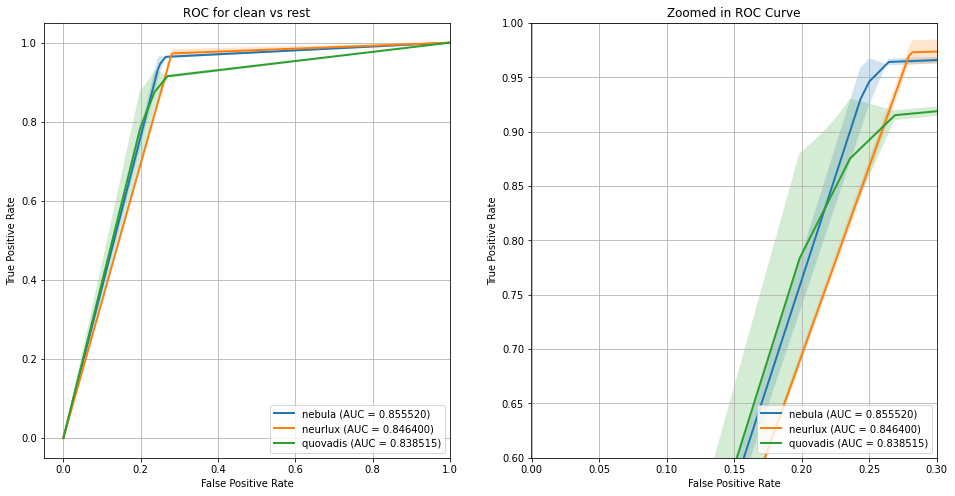

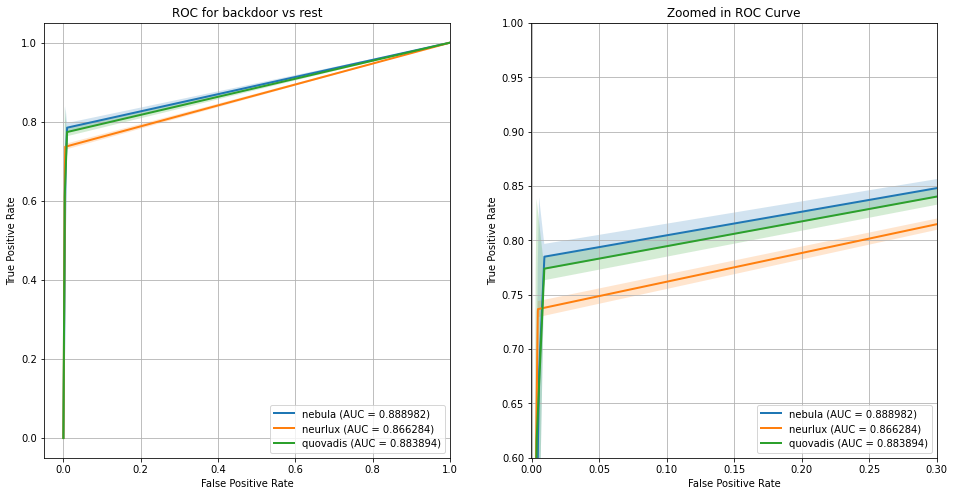

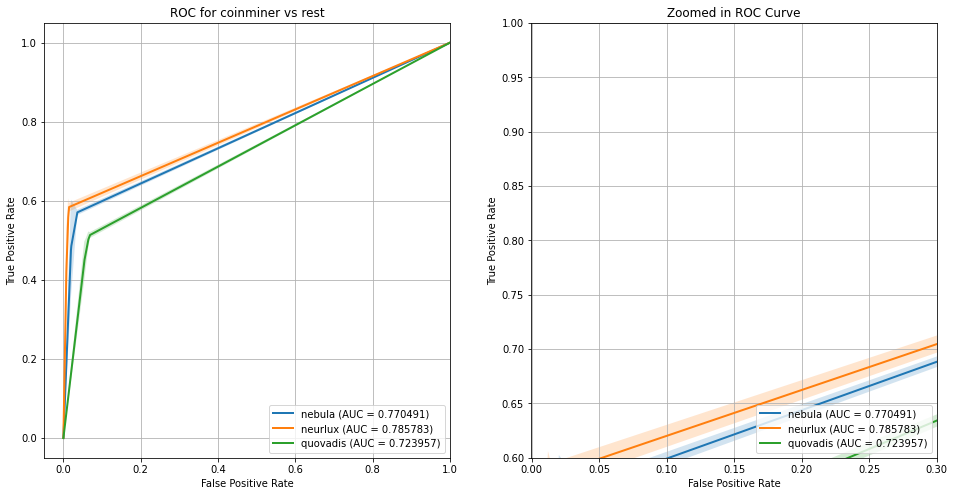

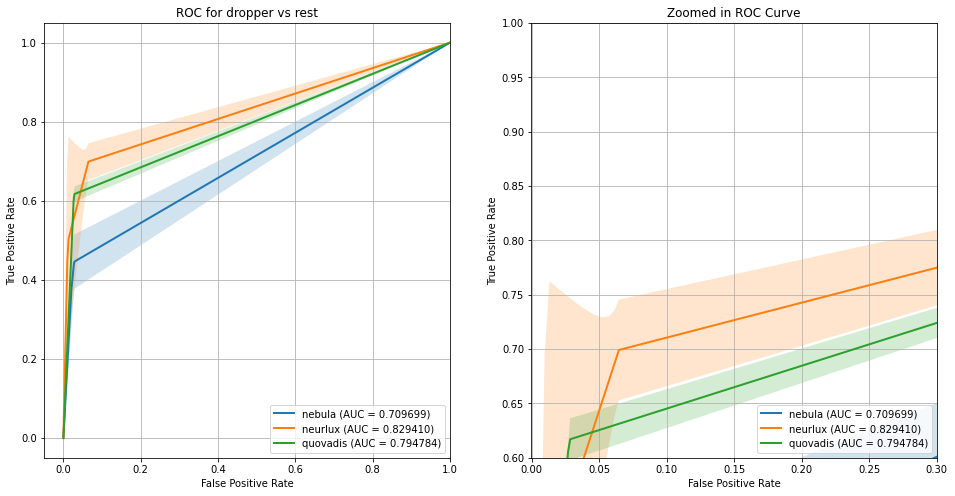

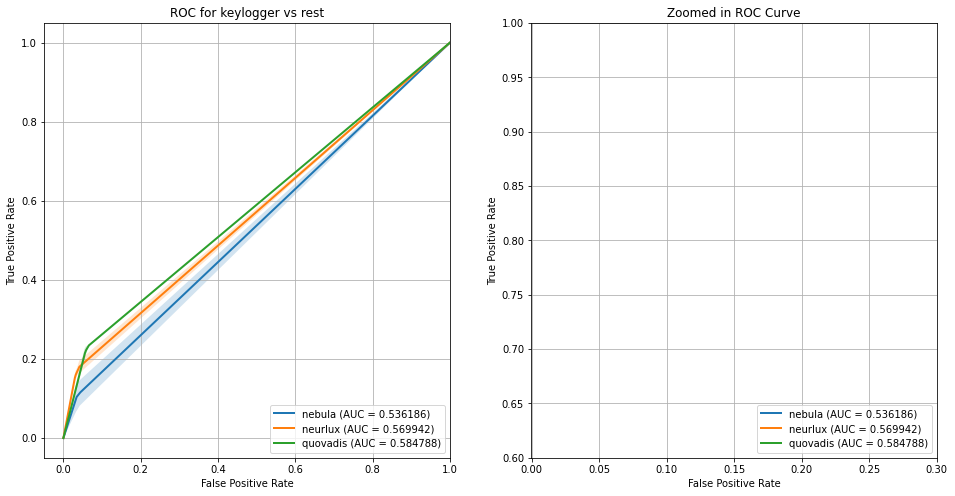

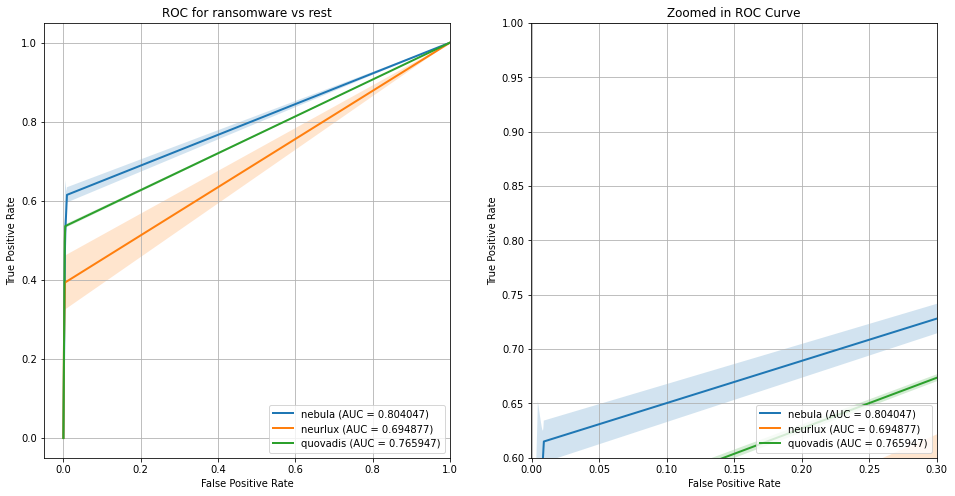

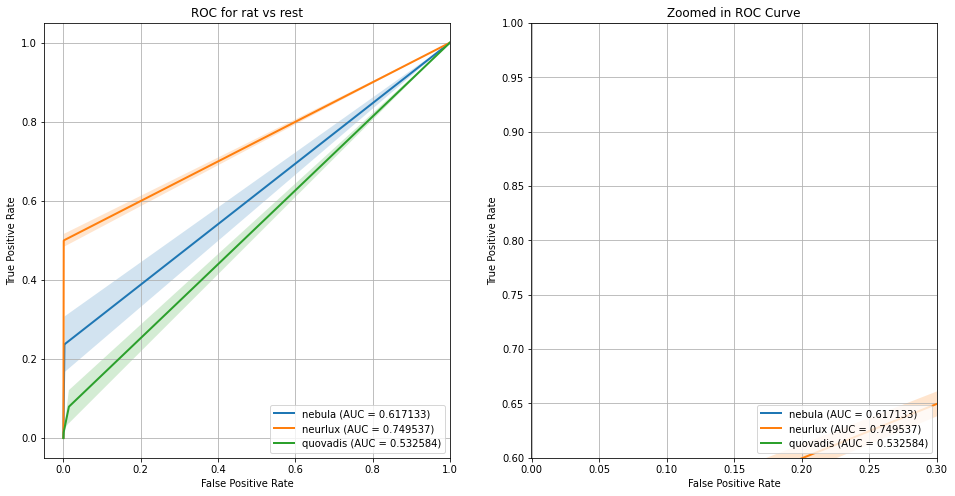

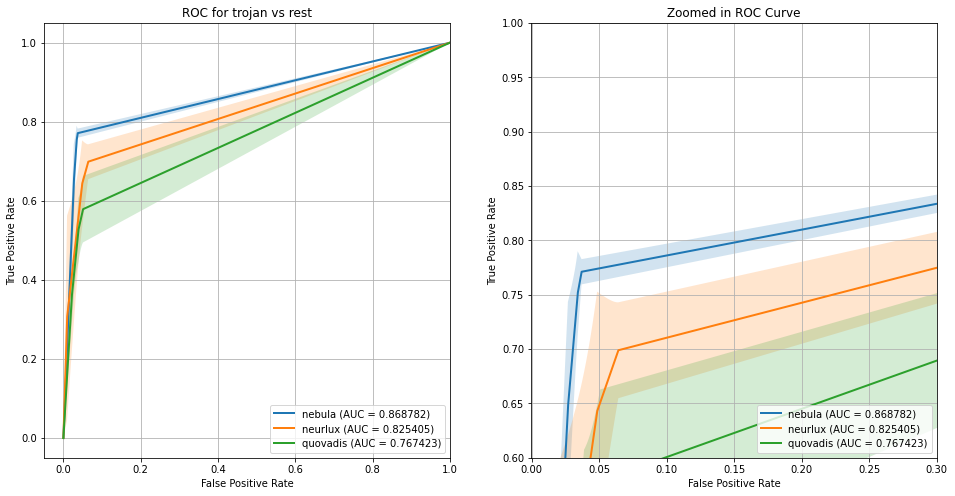

In [6]:
for selected_label in SPEAKEASY_LABELMAP.keys():
    metrics_label = {k: v[selected_label] for k, v in metrics_test.items()}
    base_fpr_test, tprs_mean_test, tprs_std_test = allign_metrics(metrics_label)

    df, axs_test = report_alligned_metrics(
        base_fpr_test,
        tprs_mean_test,
        tprs_std_test,
        metrics_label,
        metrics_full=True
    )
    # suptitle to refer label
    axs_test[0].set_title(f"ROC for {selected_label} vs rest")
    print(selected_label)
    print(df[df.columns[0:1].tolist() + df.columns[-5:].tolist()])